# Week7 - Decision Tree Lab & HW

## LAB

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).


## HW

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [ ]:
# DON'T CHANGE ANYTHING HERE....

random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )

    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000

    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]

    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6

    remove_values(df, df.columns, perc=0.05)

    return df, pd.Series(y)

X, y = create_df()

First few rows of the dataset:
         f1         f2           f3        f4        f5 f6
0  3.083178   3.022878  1276.390696 -2.672085  1.085629  B
1       NaN   1.764094  -873.709051  2.084035  0.387268  A
2  8.663599        NaN  -563.461158 -0.044922  2.512673  A
3       NaN   3.899908   753.129656  1.565944 -3.771516  A
4  0.684772  22.623978  -392.739840 -0.136113 -2.028027  A

Distribution of target variable:
0    500009
1    499991
dtype: int64


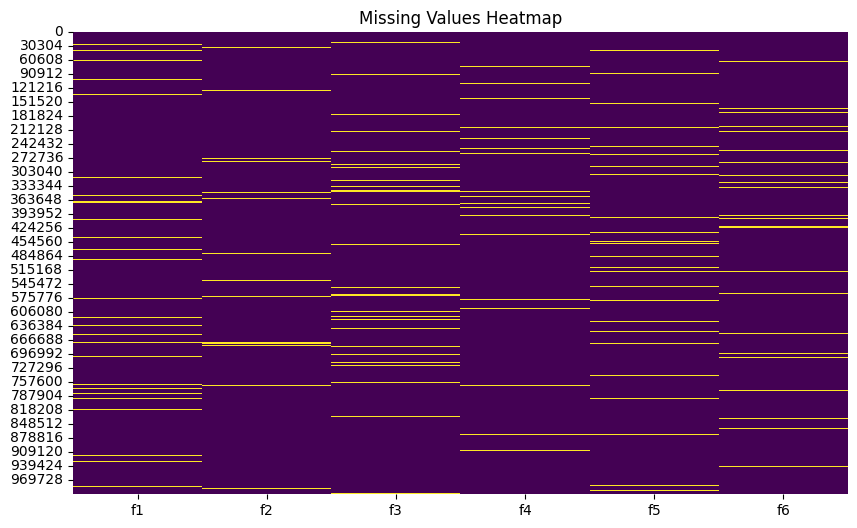

<ipython-input-6-f5cbcb1448d1>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set1')


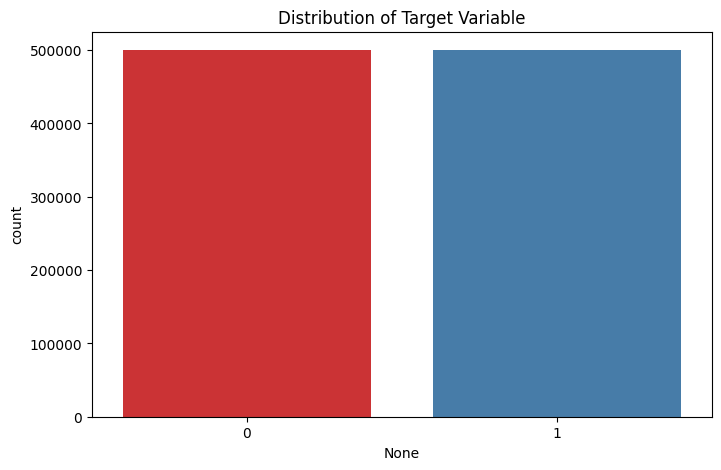

In [ ]:
print("First few rows of the dataset:")
print(X.head())


# Distribution of target variable
print("\nDistribution of target variable:")
print(y.value_counts())

plt.figure(figsize=(10, 6))
sns.heatmap(X.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette='Set1')
plt.title("Distribution of Target Variable")
plt.show()

In [ ]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


<Axes: >

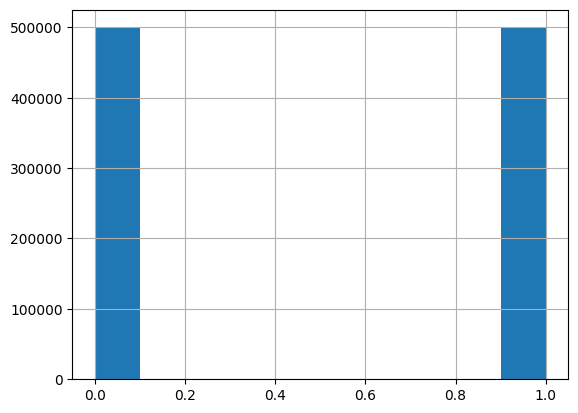

In [ ]:
y.hist()

In [ ]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64



```
# This is formatted as code
```

Explainations... Given that it strikes a balance between recall and precision, the F1-score would be a good metric for this binary classification assignment. This makes it useful in scenarios where there is a class imbalance and where false positives and false negatives are of equal importance.




Explain your gameplan... 1. To get the data ready for modeling, apply preprocessing techniques include encoding category features, scaling numerical features, and handling missing values. 2. Try out various classification techniques, taking into account the features of the dataset and the nature of the problem, such as Random Forest, Decision Tree, and Logistic Regression. 3. To guarantee generalizability, evaluate the model's performance using suitable evaluation measures, such as the F1-score on a holdout dataset or using cross-validation. 4. Aim for continuous improvement by iterating on the model and preprocessing procedures based on performance metrics and ideas from analysis and experimentation.



In [ ]:
# create processing pipeline

In [ ]:
numerical_features = ['f1', 'f2', 'f3', 'f4', 'f5']
categorical_features = ['f6']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

processing_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


processing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['f6'])])

## HW

In [ ]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())])

In [ ]:
from sklearn.model_selection import train_test_split
import random


subset_size = 0.1


subset_index = random.sample(range(len(X)), int(len(X) * subset_size))
X_subset = X.iloc[subset_index]
y_subset = y.iloc[subset_index]

X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)



dt_param_grid = {
    'ml__criterion': ['gini', 'entropy'],
    'ml__max_depth': [None, 5, 10, 20],
    'ml__min_samples_split': [2, 5, 10],
    'ml__min_samples_leaf': [1, 2, 4]
}

scoring ='f1'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

In [ ]:
dt_gcv_results.best_params_

{'ml__criterion': 'gini',
 'ml__max_depth': 10,
 'ml__min_samples_leaf': 4,
 'ml__min_samples_split': 5}

In [ ]:
dt_gcv_results.score(X_train, y_train)

0.836748901912634

In [ ]:
dt_gcv_results.score(X_test, y_test)

0.8152614511552493

Explain __shortly__ your findings how did you address the issues.

In [ ]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [ ]:
from sklearn.model_selection import train_test_split
import random

subset_size = 0.01

subset_index = random.sample(range(len(X)), int(len(X) * subset_size))
X_subset = X.iloc[subset_index]
y_subset = y.iloc[subset_index]

X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
rf_param_grid = {
    'ml__n_estimators': [80, 150, 250],
    'ml__max_depth': [None, 10, 20],
    'ml__min_samples_split': [2, 5, 10],
    'ml__min_samples_leaf': [1, 2, 4]
}
scoring = 'f1'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

In [21]:
rf_gcv_results.best_params_

{'ml__max_depth': None,
 'ml__min_samples_leaf': 2,
 'ml__min_samples_split': 5,
 'ml__n_estimators': 80}

In [22]:
rf_gcv_results.score(X_train, y_train)

0.9563771267749777

In [23]:
rf_gcv_results.score(X_test, y_test)

0.8215031315240084

\Explain __shortly__ your findings how did you address the issues.
The mean accuracy score of approximately 0.956 on the training set indicates high accuracy in classifying instances, suggesting that the model has learned the training data well. The mean accuracy score of approximately 0.822 on the test set suggests that the RandomForestClassifier maintains good performance on unseen data, although it may slightly overfit the training data compared to the Decision Tree classifier.


Explain which model would you go with?

In [24]:
# create a new pipeline with the winner model and the best params
# evaluate the same results


from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

best_rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1)


best_rf_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', best_rf_model)
])


best_rf_pipeline.fit(X_train, y_train)


train_score = best_rf_pipeline.score(X_train, y_train)
print("Accuracy on the training set:", train_score)


test_score = best_rf_pipeline.score(X_test, y_test)
print("Accuracy on the test set:", test_score)


Accuracy on the training set: 1.0
Accuracy on the test set: 0.8295


Explain results

The results indicate that the Random Forest Classifier with the best parameters achieved perfect accuracy (1.0) on the training set, meaning it correctly classified all instances in the training data. However, on the test set, the accuracy dropped slightly to 0.8295, indicating that the model's performance generalized well to unseen data. An accuracy of approximately 0.82 indicates that the Random Forest Classifier is an effective model for the classification task at hand, demonstrating strong generalization performance and predictive accuracy on unseen data.